# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>
## <center>Trabajo Práctico 2 : Críticas Cinematográficas </center>
#### Grupo 29:
* Alen Davies Leccese - 107084
* Luca Lazcano - 107044

## Imports y carga de datos

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

import xgboost as xgb
from xgboost import XGBClassifier
import pickle
import re

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

RANDOM_STATE = 42

In [46]:
train = pd.read_csv('Datasets/train.csv')
test = pd.read_csv('Datasets/test.csv')

In [47]:
shape = train.shape
print("Filas: %d Columnas: %d" % (shape[0], shape[1]))

Filas: 50000 Columnas: 3


In [48]:
train.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


## Preprocesamiento

Comenzamos por convertir a tipo str y a minúscula la columna ``'review_es'``

In [49]:
test['review_es'] = test['review_es'].astype(str).str.lower()
train['review_es'] = train['review_es'].astype(str).str.lower()
train.head()

,ID,review_es,sentimiento
0,0,uno de los otros críticos ha mencionado que de...,positivo
1,1,una pequeña pequeña producción.la técnica de f...,positivo
2,2,pensé que esta era una manera maravillosa de p...,positivo
3,3,"básicamente, hay una familia donde un niño peq...",negativo
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo


Usamos RegexpTokenizer de nltk para splitear las reviews en palabras. Usamos la expresión regular ``\w+`` que representa una expresión regular que coincide con una o más letras, números o guiones bajos.

In [50]:
regexp = RegexpTokenizer('\w+')

test['review_token'] = test['review_es'].apply(regexp.tokenize)
train['review_token'] = train['review_es'].apply(regexp.tokenize)
train.head()

,ID,review_es,sentimiento,review_token
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[uno, de, los, otros, críticos, ha, mencionado..."
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[una, pequeña, pequeña, producción, la, técnic..."
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pensé, que, esta, era, una, manera, maravillo..."
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[básicamente, hay, una, familia, donde, un, ni..."
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[el, amor, en, el, tiempo, de, petter, mattei,..."


Las stopwords (palabras vacías), son palabras muy comunes en un idioma que generalmente no aportan un significado importante al análisis de texto.

Las stopwords incluyen palabras como artículos ("el", "la", "los", "las"), pronombres ("yo", "tú", "él", "ella"), preposiciones ("a", "de", "en", "con").

Las stopwords se eliminan para reducir el ruido y el tamaño del vocabulario en el texto analizado, centrándose en las palabras clave. Al eliminar estas palabras vacías, se puede mejorar el rendimiento de algoritmos de procesamiento de texto.

In [51]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\davies\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
stopwords_es = nltk.corpus.stopwords.words("spanish")
print(stopwords_es)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [53]:
test['review_token'] = test['review_token'].apply(lambda x: [item for item in x if item not in stopwords_es])
train['review_token'] = train['review_token'].apply(lambda x: [item for item in x if item not in stopwords_es])
train.head()

,ID,review_es,sentimiento,review_token
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[críticos, mencionado, después, ver, solo, 1, ..."
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, producción, técnica, filmac..."
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pensé, manera, maravillosa, pasar, tiempo, fi..."
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[básicamente, familia, niño, pequeño, jake, pi..."
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, película, visua..."


In [54]:
stopwords_en = nltk.corpus.stopwords.words("english")
print(stopwords_en)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [55]:
test['review_token'] = test['review_token'].apply(lambda x: [item for item in x if item not in stopwords_en])
train['review_token'] = train['review_token'].apply(lambda x: [item for item in x if item not in stopwords_en])

Ahora vamos a eliminar palabras poco frecuentes manteniendo solo las palabras que tienen más de 2 letras.

In [56]:
test['review_string'] = test['review_token'].apply(lambda x: ' '.join([item for item in x if len(item) > 3]))
train['review_string'] = train['review_token'].apply(lambda x: ' '.join([item for item in x if len(item) > 3]))
train.head()

,ID,review_es,sentimiento,review_token,review_string
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[críticos, mencionado, después, ver, solo, 1, ...",críticos mencionado después solo episodio enga...
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, producción, técnica, filmac...",pequeña pequeña producción técnica filmación i...
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pensé, manera, maravillosa, pasar, tiempo, fi...",pensé manera maravillosa pasar tiempo semana v...
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[básicamente, familia, niño, pequeño, jake, pi...",básicamente familia niño pequeño jake piensa z...
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, película, visua...",amor tiempo petter mattei película visualmente...


Creamos una lista con todas las palabras.

In [57]:
all_words = ' '.join([word for word in train['review_string']])

Tokenizamos la lista de palabras.

In [58]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\davies\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\davies\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [59]:
tokenized_words = nltk.tokenize.word_tokenize(all_words)

Utilizamos la función FreqDist de nltk para calcular la frecuencia de cada palabra.

In [60]:
freq = FreqDist(tokenized_words)
freq

FreqDist({'película': 151878, 'solo': 28787, 'películas': 28704, 'historia': 26109, 'realmente': 23201, 'bien': 17876, 'mejor': 17561, 'gran': 16966, 'puede': 16037, 'hace': 15644, ...})

Ahora podemos utilizar esto para descartar la palabras menos frecuentes.

In [61]:
test['review_string_freq'] = test['review_token'].apply(lambda x: ' '.join([item for item in x if freq[item] >= 6 ]))
train['review_string_freq'] = train['review_token'].apply(lambda x: ' '.join([item for item in x if freq[item] >= 6 ]))
train.head()

,ID,review_es,sentimiento,review_token,review_string,review_string_freq
0,0,uno de los otros críticos ha mencionado que de...,positivo,"[críticos, mencionado, después, ver, solo, 1, ...",críticos mencionado después solo episodio enga...,críticos mencionado después solo episodio enga...
1,1,una pequeña pequeña producción.la técnica de f...,positivo,"[pequeña, pequeña, producción, técnica, filmac...",pequeña pequeña producción técnica filmación i...,pequeña pequeña producción técnica filmación i...
2,2,pensé que esta era una manera maravillosa de p...,positivo,"[pensé, manera, maravillosa, pasar, tiempo, fi...",pensé manera maravillosa pasar tiempo semana v...,pensé manera maravillosa pasar tiempo semana v...
3,3,"básicamente, hay una familia donde un niño peq...",negativo,"[básicamente, familia, niño, pequeño, jake, pi...",básicamente familia niño pequeño jake piensa z...,básicamente familia niño pequeño jake piensa z...
4,4,"el ""amor en el tiempo"" de petter mattei es una...",positivo,"[amor, tiempo, petter, mattei, película, visua...",amor tiempo petter mattei película visualmente...,amor tiempo mattei película visualmente impres...


Graficamos las palabras más frecuentes.

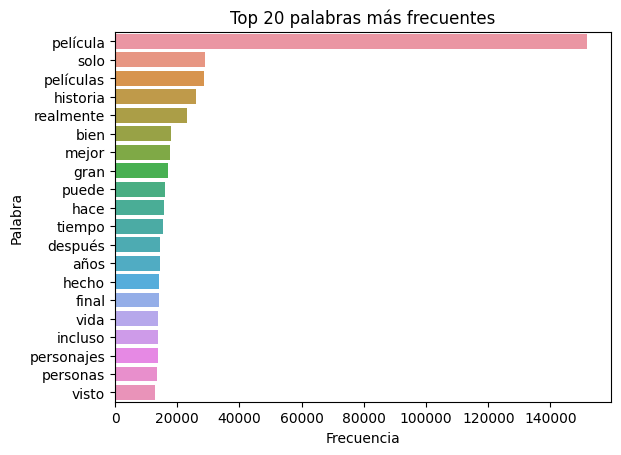

In [62]:
top20 = pd.Series(dict(freq.most_common(20)))
sns.barplot(y=top20.index, x=top20.values).set(title='Top 20 palabras más frecuentes', xlabel='Frecuencia', ylabel='Palabra')

plt.show()

### Bag of Words

La técnica Bag of Words es una forma de representar datos de texto en aprendizaje automático. El concepto básico es tratar cada documento de texto como una "bolsa" de palabras, donde se ignora el orden y la estructura gramatical de las palabras. En lugar de eso, se enfoca únicamente en la presencia y frecuencia de las palabras en el texto.

Vamos a utilizar ``TfidfVectorizer`` de scikit-learn que implementa la técnica de ponderación TF-IDF (Term Frequency-Inverse Document Frequency) para convertir datos de texto en características numéricas.

In [63]:
vectorizer = TfidfVectorizer()
train_fid = vectorizer.fit_transform(train.review_string_freq)
test_fid = vectorizer.transform(test.review_string_freq)

## Split train/test

Dvidimos el dataset en train y test.

In [64]:
x_train, x_test, y_train, y_test = train_test_split(train_fid,
                                                    train.sentimiento, 
                                                    test_size=0.3,
                                                    random_state=RANDOM_STATE, shuffle=True)

## Bayes Naive

Realizamos optimización de hiperparámetros con Random Search.

In [70]:
#Cantidad de combinaciones que quiero probar
n=15

#Grilla de Parámetros a probar
params_grid={ 'alpha': [0.5, 1.0, 2.0, 5.0],
               'class_prior': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5], [0.6, 0.4]],
               'fit_prior': [True, False],
               'force_alpha': [True, False]
             }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True)

#Clasificador
NB_model = MultinomialNB()

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score, pos_label='positivo')

#Random Search Cross Validation
rand_NB = RandomizedSearchCV(estimator = NB_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv=kfoldcv,
                              n_iter = n,
                              random_state = RANDOM_STATE) 

rand_NB.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=MultinomialNB(), n_iter=15,
                   param_distributions={'alpha': [0.5, 1.0, 2.0, 5.0],
                                        'class_prior': [None, [0.1, 0.9],
                                                        [0.2, 0.8], [0.3, 0.7],
                                                        [0.4, 0.6], [0.5, 0.5],
                                                        [0.6, 0.4]],
                                        'fit_prior': [True, False],
                                        'force_alpha': [True, False]},
                   random_state=42,
                   scoring=make_scorer(f1_score, pos_label=positivo))

Vemos cuales fueron los mejores hiperparámetros y la mejor métrica obtenida.

In [71]:
print('Mejores parámetros: {}'.format(rand_NB.best_params_))
print('Mejor métrica: {}'.format(rand_NB.best_score_))

Mejores parámetros: {'force_alpha': True, 'fit_prior': True, 'class_prior': None, 'alpha': 0.5}
Mejor métrica: 0.853150554537686


Entrenamos el modelo de Bayes Naive con los mejores hiperparámetros y realizamos las predicciones.

In [72]:
NB_model = MultinomialNB().set_params(**rand_NB.best_params_)
NB_model.fit(x_train, y_train)

y_pred = NB_model.predict(x_test)

In [73]:
print(f'Best Training Accuracy: {NB_model.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {NB_model.score(x_test, y_test)}')

Best Training Accuracy: 0.9105428571428571
Best Testing Accuracy: 0.8544


### Métricas

Calculamos las métricas de accuracy, precision, recall y f1-score.

In [74]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label='positivo')
f1 = f1_score(y_test, y_pred, pos_label='positivo')
precision = precision_score(y_test, y_pred, pos_label='positivo')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8544
Recall: 0.8491237317169588
Precision: 0.8611519444073232
f1 score: 0.8550955414012738


In [75]:
#Reporte de Clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negativo       0.85      0.86      0.85      7411
    positivo       0.86      0.85      0.86      7589

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



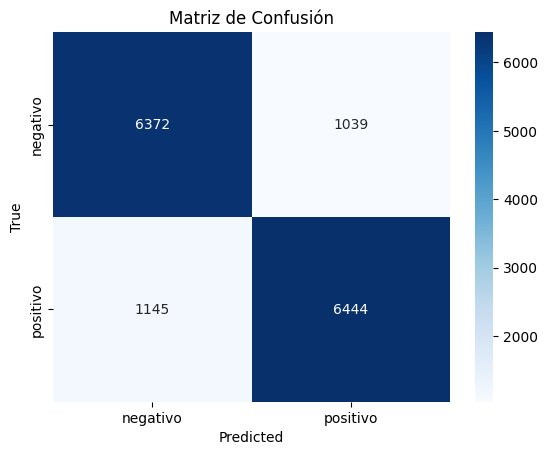

In [76]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g').set(title='Matriz de Confusión', xlabel='Predicted', ylabel='True', xticklabels=['negativo', 'positivo'], yticklabels=['negativo', 'positivo'])
plt.show()

### Submission

In [77]:
pickle.dump(NB_model, open('NB_grupo29.pickle', 'wb'))

In [78]:
X_submission_NB = test_fid
y_pred_test_NB = NB_model.predict(X_submission_NB)
df_submission_NB = pd.DataFrame({'ID': test['ID'], 'sentimiento': y_pred_test_NB})
df_submission_NB.to_csv('NB02.csv', index=False)

## Random Forest

In [79]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid={ 'n_estimators': [100, 200, 300, 400, 500],
                'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 35, 40],
                'max_depth': [None],
                'max_samples': [None, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0],
                'ccp_alpha': [0.0, 0.001, 0.01, 0.1, 1.0],
             }

#Clasificador
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_rf = RandomizedSearchCV(estimator = rf_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              n_iter = n,
                              random_state=RANDOM_STATE) 

rand_rf.fit(x_train, y_train)
rand_rf.cv_results_['mean_test_score'] 

KeyboardInterrupt: 

In [ ]:
print('Mejores parámetros: {}'.format(rand_rf.best_params_))
print('Mejor métrica: {}'.format(rand_rf.best_score_))

Mejores parámetros: {'force_alpha': False, 'fit_prior': False, 'class_prior': [0.4, 0.6], 'alpha': 1.0}
Mejor métrica: 0.8497132270696692


In [1]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE).set_params(**rand_rf.best_params_)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

NameError: name 'make_pipeline' is not defined

In [ ]:
print(f'Best Training Accuracy: {rf_model.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {rf_model.score(x_test, y_test)}')

Best Training Accuracy: 0.8953142857142857
Best Testing Accuracy: 0.8395333333333334


### Métricas

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label='positivo')
f1 = f1_score(y_test, y_pred, pos_label='positivo')
precision = precision_score(y_test, y_pred, pos_label='positivo')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8395333333333334
Recall: 0.928053762023982
Precision: 0.7909928122192273
f1 score: 0.8540592978839507


In [ ]:
#Reporte de Clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negativo       0.91      0.75      0.82      7411
    positivo       0.79      0.93      0.85      7589

    accuracy                           0.84     15000
   macro avg       0.85      0.84      0.84     15000
weighted avg       0.85      0.84      0.84     15000



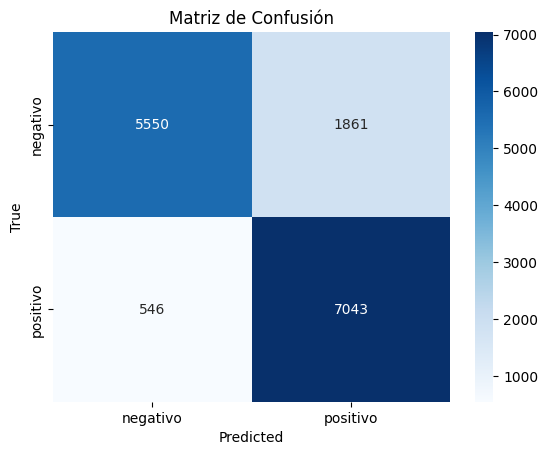

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g').set(title='Matriz de Confusión', xlabel='Predicted', ylabel='True', xticklabels=['negativo', 'positivo'], yticklabels=['negativo', 'positivo'])
plt.show()

### Submission

In [ ]:
pickle.dump(rf_model, open('rf_grupo29.pickle', 'wb'))

In [ ]:
X_submission_rf = test_fid
y_pred_test_rf = rf_model.predict(X_submission_rf)
y_pred_test_rf
df_submission_rf = pd.DataFrame({'ID': test['ID'], 'sentimiento': y_pred_test_rf})
df_submission_rf.to_csv('rf01.csv', index=False)

## XGBoost

In [95]:
label_map = {'negativo': 0, 'positivo': 1}
y_train_mapped = y_train.map(label_map)
y_test_mapped = y_test.map(label_map)

In [96]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid= {'learning_rate': np.linspace(0.05, 0.5, 50),
                'gamma': [0,1,2],
                'max_depth': list(range(2,10)),
                'subsample': np.linspace(0, 1, 20),
                'lambda': [0,1,2],
                'alpha' : [1],
                'n_estimators': list(range(10,161,10))
              }

#Clasificador
xgb_model = XGBClassifier(random_state=RANDOM_STATE)

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_xgb = RandomizedSearchCV(estimator = xgb_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              n_iter = n,
                              random_state=RANDOM_STATE) 

rand_xgb.fit(x_train, y_train_mapped)
rand_xgb.cv_results_['mean_test_score'] 

KeyboardInterrupt: 

In [ ]:
print('Mejores parámetros: {}'.format(rand_xgb.best_params_))
print('Mejor métrica: {}'.format(rand_xgb.best_score_))

Mejores parámetros: {'force_alpha': False, 'fit_prior': False, 'class_prior': [0.4, 0.6], 'alpha': 1.0}
Mejor métrica: 0.8497132270696692


In [ ]:
xgb_model = XGBClassifier(random_state=RANDOM_STATE).set_params(**rand_xgb.best_params_)
xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_test)

In [84]:
print(f'Best Training Accuracy: {xgb_model.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {xgb_model.score(x_test, y_test)}')

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=['negativo' 'positivo'] and y_pred=[0 1]. Make sure that the predictions provided by the classifier coincides with the true labels.

### Métricas

In [89]:
accuracy = accuracy_score(y_test_mapped, y_pred)
recall = recall_score(y_test_mapped, y_pred)
f1 = f1_score(y_test_mapped, y_pred)
precision = precision_score(y_test_mapped, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8301333333333333
Recall: 0.8533403610488866
Precision: 0.8186070029073442
f1 score: 0.8356129032258065


In [91]:
#Reporte de Clasificación
print(classification_report(y_test_mapped, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      7411
           1       0.82      0.85      0.84      7589

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000



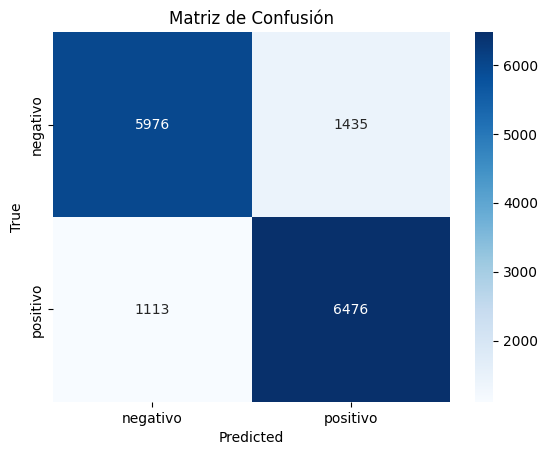

In [92]:
#Matriz de Confusión
cm = confusion_matrix(y_test_mapped, y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g').set(title='Matriz de Confusión', xlabel='Predicted', ylabel='True', xticklabels=['negativo', 'positivo'], yticklabels=['negativo', 'positivo'])
plt.show()

### Submission

In [93]:
pickle.dump(xgb_model, open('xgb_grupo29.pickle', 'wb'))

In [97]:
X_submission_xgb = test_fid
y_pred_test_xgb = xgb_model.predict(X_submission_xgb)

label_map = {0: 'negativo', 1: 'positivo'}
y_pred_test_xgb = y_pred_test_xgb.map(label_map)

df_submission_xgb = pd.DataFrame({'ID': test['ID'], 'sentimiento': y_pred_test_xgb})
df_submission_xgb.to_csv('xgb00.csv', index=False)

NotFittedError: need to call fit or load_model beforehand

## Red Neuronal

## Ensamble